# Examining Bivariante and Multivariante Relationships between Features and Targets

In this chapter, we will look at the correlation between possible features and target variables.

**Bivariate exploratory** analysis, using crosstabs (two-way frequencies), correlations, scatter plots, and grouped boxplotx can uncover key issues for modeling. Common issues includes high correlation between features and non-linear relationships between feature and target variables.


We will also use **multivariante** techniques to understand the relationship between features.

We will cover the following topics:
- identifying outliers and extreme values in bivariante relationships
- using scatter plots to view bivariante relationships between continuous features
- using grouped boxplots to view bivariante relationships between continuous and categorical features
- using linear regression to identify data points with significant influence
- using K-nearest neighbors to find outliers
- using Isolation Forest to find outliers

## Identifying outliers and extreme values in bivariante relationships

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

covid_totals = pd.read_csv("./data/covidtotals.csv")
covid_totals.set_index("iso_code", inplace=True)
covid_totals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, AFG to ZWE
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lastdate             221 non-null    object 
 1   location             221 non-null    object 
 2   total_cases          192 non-null    float64
 3   total_deaths         185 non-null    float64
 4   total_cases_mill     192 non-null    float64
 5   total_deaths_mill    185 non-null    float64
 6   population           221 non-null    float64
 7   population_density   206 non-null    float64
 8   median_age           190 non-null    float64
 9   gdp_per_capita       193 non-null    float64
 10  aged_65_older        188 non-null    float64
 11  total_tests_thous    13 non-null     float64
 12  life_expectancy      217 non-null    float64
 13  hospital_beds_thous  170 non-null    float64
 14  diabetes_prevalence  200 non-null    float64
 15  region               221 non-null    object

A great place to start with our examination of bivariante relationships is with correlations.

In [7]:
total_vars = ["location", "total_cases_mill", "total_deaths_mill"]
demo_vars = [
    "population_density",
    "aged_65_older",
    "gdp_per_capita",
    "life_expectancy",
    "diabetes_prevalence",
]
covid_keys = covid_totals.loc[:, total_vars + demo_vars]

# Getting the Pearson correlation matrix for these features.
corr_matrix = covid_keys.corr()
corr_matrix

,total_cases_mill,total_deaths_mill,population_density,aged_65_older,gdp_per_capita,life_expectancy,diabetes_prevalence
total_cases_mill,1.000000,0.709783,0.043152,0.533905,0.464955,0.570582,0.023023
total_deaths_mill,0.709783,1.000000,-0.033728,0.530196,0.222839,0.459677,-0.009011
population_density,0.043152,-0.033728,1.000000,0.063253,0.408957,0.231153,0.012559
aged_65_older,0.533905,0.530196,0.063253,1.000000,0.492855,0.729937,-0.063584
gdp_per_capita,0.464955,0.222839,0.408957,0.492855,1.000000,0.681222,0.123718
life_expectancy,0.570582,0.459677,0.231153,0.729937,0.681222,1.000000,0.190043
diabetes_prevalence,0.023023,-0.009011,0.012559,-0.063584,0.123718,0.190043,1.000000


^ There is a strong positive correlation of 0.71 between cases and deaths per million.

The percentage of the population that is aged 65 or older is positively correlated with cases and deaths, at 0.53 for both.

Life expectancy is also highly correlated with cases per million.

We can visualize the correlation matrix as a heat map. Pay attention to the cells shown with warmer colors.

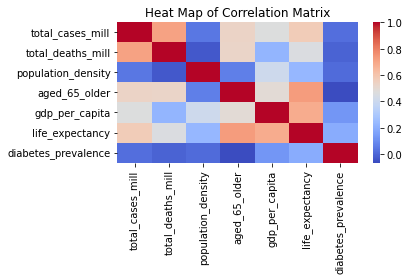

In [8]:
sns.heatmap(
    corr_matrix,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns,
    cmap="coolwarm",
)
plt.title("Heat Map of Correlation Matrix")
plt.tight_layout()

Let us take a closer look at the relationship between `total_cases_mill` and `total_deaths_mill`. 

One way to get a better sense of this than just with a correlation coefficient is by comparing the high and low values for each and seeing how they move together.

In the following code, we use `qcut` method to create a categorical feature with five values distributed relatively evenly, from very low to very high, for cases and deaths. 

In [14]:
covid_keys["total_cases_q"] = pd.qcut(
    covid_keys["total_cases_mill"],
    labels=["very low", "low", "medium", "high", "very high"],
    q=5,
    precision=0,
)

print(covid_keys["total_cases_q"].value_counts())

very low     39
very high    39
low          38
medium       38
high         38
Name: total_cases_q, dtype: int64


In [15]:
covid_keys["total_deaths_q"] = pd.qcut(
    covid_keys["total_deaths_mill"],
    labels=["very low", "low", "medium", "high", "very high"],
    q=5,
    precision=0,
)

print(covid_keys["total_deaths_q"].value_counts())

very low     37
low          37
medium       37
high         37
very high    37
Name: total_deaths_q, dtype: int64


In [18]:
pd.crosstab(covid_keys.total_cases_q, covid_keys.total_deaths_q)

total_deaths_q,very low,low,medium,high,very high
total_cases_q,,,,,
very low,27,7,0,0,0
low,9,24,4,0,0
medium,1,6,23,6,1
high,0,0,6,21,11
very high,0,0,4,10,25


^ There are 27 countries with very low cases and very low deaths, and 25 countries with very high cases and very high deaths.

The interesting counts are those not on the diagonal, such as the four countries with very high cases but only medium deaths.

In [17]:
covid_keys.mean()

total_cases_mill       36649.371823
total_deaths_mill        683.136995
population_density       453.287850
aged_65_older              8.606995
gdp_per_capita         19141.314611
life_expectancy           73.368664
diabetes_prevalence        8.442500
dtype: float64

In [20]:
covid_totals.loc[
    (covid_keys.total_cases_q == "very high") & (covid_keys.total_deaths_q == "medium")
].T

iso_code,CYP,KWT,MDV,QAT
lastdate,2021-07-07,2021-07-07,2021-07-07,2021-07-07
location,Cyprus,Kuwait,Maldives,Qatar
total_cases,80588.0,369227.0,74724.0,222918.0
total_deaths,380.0,2059.0,213.0,596.0
total_cases_mill,90751.741,86458.624,138239.027,77373.606
total_deaths_mill,427.926,482.138,394.049,206.868
population,888005.0,4270563.0,540542.0,2881060.0
population_density,127.657,232.128,1454.433,227.322
median_age,37.3,33.7,30.6,31.9
gdp_per_capita,32415.132,65530.537,15183.616,116935.6


In [21]:
covid_totals.loc[
    (covid_keys.total_cases_q == "medium") & (covid_keys.total_deaths_q == "very high")
].T

iso_code,MEX
lastdate,2021-07-07
location,Mexico
total_cases,2558369.0
total_deaths,234192.0
total_cases_mill,19842.662
total_deaths_mill,1816.389
population,128932753.0
population_density,66.444
median_age,29.3
gdp_per_capita,17336.469


## Use Scatter plots to view bivariante relationships between continuous features

We can use scatter plots to get a more complete picture of the relationships between two features that what can be detected by a correlation coefficient alone.

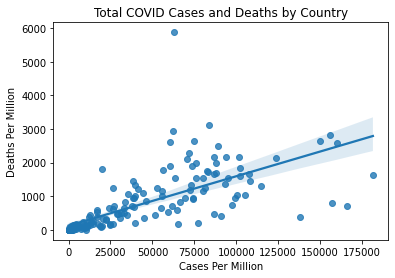

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

covid_totals = pd.read_csv("./data/covidtotals.csv")
covid_totals.set_index("iso_code", inplace=True)

ax = sns.regplot(x="total_cases_mill", y="total_deaths_mill", data=covid_totals)
_ = ax.set(
    xlabel="Cases Per Million",
    ylabel="Deaths Per Million",
    title="Total COVID Cases and Deaths by Country",
)

^ The regression line is an estimate of the relationship between cases per million and deaths per million.

The _slope_ of the line indicates how much we can expet deaths per million to increase with a 1-unit increase in cases per million.

Those points on the scatter plot that are significantly above the regression line should be examined more closely.

The country with deaths per million near 6,000 and cases per million below 75,000 is clearly an outlier.

In [26]:
covid_totals.loc[
    (covid_totals.total_cases_mill < 75_000) & (covid_totals.total_deaths_mill > 5500)
].T

iso_code,PER
lastdate,2021-07-07
location,Peru
total_cases,2071637.0
total_deaths,193743.0
total_cases_mill,62830.483
total_deaths_mill,5876.013
population,32971846.0
population_density,25.129
median_age,29.1
gdp_per_capita,12236.706


Let's create scatter plots of people who are aged 65 and older and GDP per capita with total cases per million.

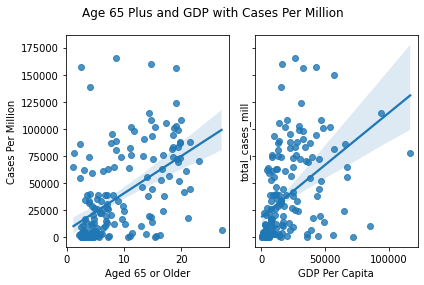

In [27]:
fig, axes = plt.subplots(1, 2, sharey=True)
sns.regplot(x=covid_totals.aged_65_older, y=covid_totals.total_cases_mill, ax=axes[0])

sns.regplot(x=covid_totals.gdp_per_capita, y=covid_totals.total_cases_mill, ax=axes[1])
axes[0].set(xlabel="Aged 65 or Older", ylabel="Cases Per Million")
axes[1].set(xlabel="GDP Per Capita")
plt.suptitle("Age 65 Plus and GDP with Cases Per Million")
plt.tight_layout()

We can use scatter plots to illustrate the relationships between two features and a target, all in one graphic.

We split the `landtemps` DataFrame into low- and high- elevation stations, with 1,000 meters as the threshold.

In [37]:
land_temps = pd.read_csv("./data/landtemps2019avgs.csv")
high = land_temps.loc[land_temps.elevation <= 1_000]
low = land_temps.loc[land_temps.elevation > 1_000]

low.shape[0], low.avgtemp.mean()

(2557, 7.583214869517569)

In [38]:
high.shape[0], high.avgtemp.mean()

(9538, 12.161417937651686)

Now, we can visualize the relationship between elevation and latitude and temperature in one scatter plot.

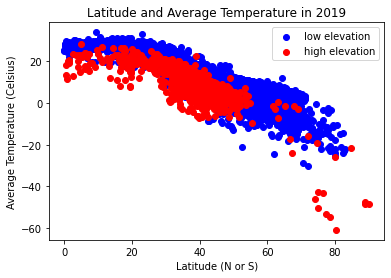

In [41]:
plt.scatter(x="latabs", y="avgtemp", c="blue", data=high)
plt.scatter(x="latabs", y="avgtemp", c="red", data=low)
plt.legend(("low elevation", "high elevation"))
plt.xlabel("Latitude (N or S)")
plt.ylabel("Average Temperature (Celsius)")
plt.title("Latitude and Average Temperature in 2019")
pass

^ Here, we can see that the temperature gradually decreases as the distance from the equator (measured in latitude) increases. We can also see that high-elevation weather stations (those with red dots) are generally below low-elevation stations - that is, they have lower temperature at similar latitude.

/usr/local/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


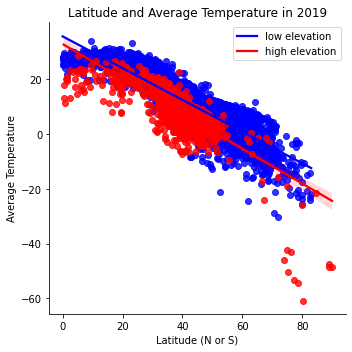

In [49]:
# Create a categorical feature for low- and high-elevation stations.
land_temps["elevation_group"] = np.where(land_temps.elevation <= 1000, "low", "high")
sns.lmplot(
    x="latabs",
    y="avgtemp",
    hue="elevation_group",
    legend_out=False,
    palette=dict(low="blue", high="red"),
    data=land_temps,
)
plt.xlabel("Latitude (N or S)")
plt.ylabel("Average Temperature")
plt.legend(("low elevation", "high elevation"))
plt.yticks(np.arange(-60, 40, step=20))
plt.title("Latitude and Average Temperature in 2019")
plt.tight_layout()

^ Here, we can see the steeper negative slope for high-elevation stations.

### Summary

Scatter plots are a go-to visualization for teasing out relationships between continuous features. 

## Using grouped boxplots to view bivariante relationships between continuous and categorical features

Scatter plots can be used to visualize the relationship between _continuous features_.
Grouped boxplots can be used to visualze the relationship between a _continuous feature_ and a _categorical_ one.

In [58]:
nls97 = pd.read_csv("data/nls97.csv")
nls97.set_index("personid", inplace=True)
nls97.sample(5).T

personid,832261,913711,393045,750934,564858
gender,Male,Male,Male,Female,Female
birthmonth,1,1,4,7,7
birthyear,1981,1981,1982,1981,1983
highestgradecompleted,NaN,12.0,17.0,12.0,NaN
maritalstatus,NaN,Divorced,Never-married,Divorced,NaN
...,...,...,...,...,...
colenroct15,NaN,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN
colenrfeb16,NaN,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN
colenroct16,NaN,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN
colenrfeb17,NaN,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN


Let's look at the distribution of weeks worked for each value of the degree that was earned.

In [61]:
def get_totals(x):
    out = {}
    out["min"] = x.min()
    out["qr1"] = x.quantile(0.25)
    out["med"] = x.median()
    out["qr3"] = x.quantile(0.75)
    out["max"] = x.max()
    out["count"] = x.count()
    return pd.Series(out)


nls97.groupby(["highestdegree"])["weeksworked17"].apply(get_totals).unstack().applymap(
    "{:.0f}".format
)

,min,qr1,med,qr3,max,count
highestdegree,,,,,,
0. None,0,0,40,52,52,510
1. GED,0,8,47,52,52,848
2. High School,0,31,49,52,52,2665
3. Associates,0,42,49,52,52,593
4. Bachelors,0,45,50,52,52,1342
5. Masters,0,46,50,52,52,538
6. PhD,0,46,50,52,52,51
7. Professional,0,47,50,52,52,97


^ For those with no degree, more than 25% had 0 weeks worked.

There is class imbalance for `highestdegree`. The counts get quite small after master's degrees and the counts for high school degrees are nearly twice that of the next largest group.

Grouped boxplots make the differences in distributions even clearer.

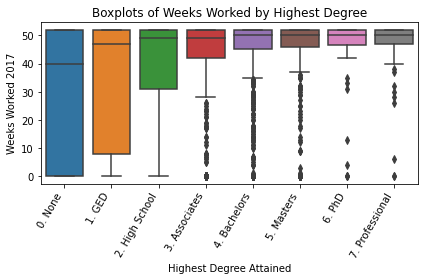

In [66]:
import seaborn as sns

myplt = sns.boxplot(
    x="highestdegree",
    y="weeksworked17",
    data=nls97,
    order=sorted(nls97.highestdegree.dropna().unique()),
)
myplt.set(
    title="Boxplots of Weeks Worked by Highest Degree",
    xlabel="Highest Degree Attained",
    ylabel="Weeks Worked 2017",
)
myplt.set_xticklabels(myplt.get_xticklabels(), rotation=60, horizontalalignment="right")
plt.tight_layout()

We can also use grouped boxplots to illustrate how the distribution of COVID-19 cases varies by region.

Text(0, 0.5, 'Region')

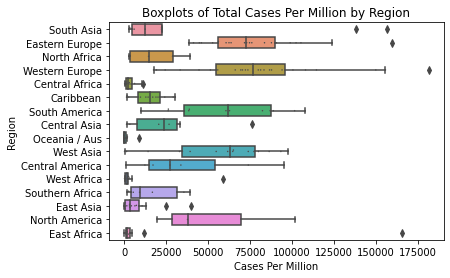

In [71]:
sns.boxplot(x="total_cases_mill", y="region", data=covid_totals)
sns.swarmplot(
    y="region",
    x="total_cases_mill",
    data=covid_totals,
    size=1.5,
    color=".3",
    linewidth=0,
)
plt.title("Boxplots of Total Cases Per Million by Region")
plt.xlabel("Cases Per Million")
plt.ylabel("Region")

## Using linear regression to identify data points with significant influence

A standard measure of influence in regression analysis is **Cook's Distance (Cook's D)**. This gives us a measure of how much our predictions would change if an observation were to be removed from data.

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [74]:
covid_totals = pd.read_csv("./data/covidtotals.csv")
covid_totals.set_index("iso_code", inplace=True)

Let's look at the distribution of total cases per million in population and some possible predictors.

In [75]:
x_vars = [
    "population_density",
    "aged_65_older",
    "gdp_per_capita",
    "diabetes_prevalence",
]

covid_totals[["total_cases_mill"] + x_vars].quantile(np.arange(0.0, 1.05, 0.25))

,total_cases_mill,population_density,aged_65_older,gdp_per_capita,diabetes_prevalence
0.00,8.52100,0.13700,1.14400,661.240,0.9900
0.25,2499.74600,36.51775,3.49675,3823.194,5.3400
0.50,19525.72650,87.25000,6.21750,12236.706,7.2000
0.75,64834.61975,213.53550,13.91750,27216.445,10.6125
1.00,181466.38200,20546.76600,27.04900,116935.600,30.5300


In [76]:
def get_linear_model(df, y_colname, x_colnames):
    """Uses statsmodel to run a linear regression model and generate
    influence statistics, including Cook's D.
    """
    df = df[[y_colname] + x_colnames].dropna()
    y = df[y_colname]
    X = df[x_colnames]
    X = sm.add_constant(X)
    lm = sm.OLS(y, X).fit()
    influence = lm.get_influence().summary_frame()

    coefficients = pd.DataFrame(
        zip(["constant"] + x_colnames, lm.params, lm.pvalues),
        columns=["features", "params", "pvalues"],
    )
    return coefficients, influence, lm

In [79]:
coefficients, influence, lm = get_linear_model(covid_totals, "total_cases_mill", x_vars)
coefficients.round(5)

,features,params,pvalues
0,constant,-1076.47109,0.86972
1,population_density,-6.90624,0.03022
2,aged_65_older,2713.91809,0.00000
3,gdp_per_capita,0.53151,0.00087
4,diabetes_prevalence,736.80903,0.24110


^ The coefficients for `population_density`, `age_65_older`, and `gdp_per_capita` are all significant at 95% level (have `p-values` less than 0.05).

The result for `population_density` is interesting since our bivariante analysis did not reveal a relationship between population density and cases per million.

The coefficient indicates a 6.9-point reduction in caes per million, with a 1-point increase in people per square mile.

We can use the `influence` DataFrame that we created to take a closer look at those observations with high **Cook's D**.

One way of defining a high **Cook's D** is by using three times the mean value for **Cook's D** for all observations.

In [82]:
influence_threshold = 3 * influence.cooks_d.mean()
covid_totals = covid_totals.join(influence[["cooks_d"]])
covid_totals_outliers = covid_totals.loc[covid_totals.cooks_d > influence_threshold]
covid_totals_outliers.shape

(13, 17)

^ We have 13 countries with **Cook's D** values above the threshold. Below we print the first five in descending order of the **Cook's D** value.

In [83]:
covid_totals_outliers[["location", "total_cases_mill", "cooks_d"] + x_vars].sort_values(
    ["cooks_d"], ascending=False
).head()

,location,total_cases_mill,cooks_d,population_density,aged_65_older,gdp_per_capita,diabetes_prevalence
iso_code,,,,,,,
BHR,Bahrain,156793.409,0.229818,1935.907,2.372,43290.705,16.52
SGP,Singapore,10709.116,0.199708,7915.731,12.922,85535.383,10.99
HKG,Hong Kong,1593.307,0.181348,7039.714,16.303,56054.920,8.33
JPN,Japan,6420.871,0.095461,347.778,27.049,39002.223,5.72
MDV,Maldives,138239.027,0.069122,1454.433,4.120,15183.616,9.19


Let's take a look at our regression model estimates if we remove Hong Kong and Singapore.

> NOTE: This is not necessarily the best approach. We are removing the observations here just to demonstrate their effect on the model.

In [84]:
coefficients, influence, lm2 = get_linear_model(
    covid_totals.drop(["HKG", "SGP"]), "total_cases_mill", x_vars
)

In [87]:
coefficients.round(5)

,features,params,pvalues
0,constant,-2864.21900,0.65276
1,population_density,26.98875,0.00532
2,aged_65_older,2669.28143,0.00000
3,gdp_per_capita,0.55307,0.00038
4,diabetes_prevalence,319.26187,0.60485


^ The big change in the model is that the population density coefficient has now changed direction. This demonstrates how sensitive the population density estimate is to outlier observations whose feature and target values may not be generalizable to the rest of the data.

### Summary

Generating influence measures with linear regression is a very useful technique, and it has the advantage that it is fairly easy to interpret. 

However, it has one important disadvantage: it assumes a _linear relationship_ between features, and that features are _normally distributed_. This is often not the case. 

## Using K-nearest neighbors to find outliers

In [96]:
!pip install -qq pyod
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler

In [102]:
covid_totals = pd.read_csv("./data/covidtotals.csv")
covid_totals.set_index("iso_code", inplace=True)

We standardize the data, which is important when we have features with very different ranges.

In [101]:
standardizer = StandardScaler()
analysis_vars = [
    "location",
    "total_cases_mill",
    "total_deaths_mill",
    "population_density",
    "diabetes_prevalence",
    "aged_65_older",
    "gdp_per_capita",
]

covid_analysis = covid_totals.loc[:, analysis_vars].dropna()
covid_analysis_stand = standardizer.fit_transform(covid_analysis.iloc[:, 1:])

Next, we can run the model and generate predictions and anomaly scores. First, we must set `contamination` to `0.1` to indicate that we want 10% of observations to be identified as outliers.

After using the `fit` method to run the KNN algorithm, we get predictions (1 if an outlier, 0 if an inlier) and an anomaly score, which is the basis of the prediction (in this case, the top 10% of anomaly scores will get a prediction of 1):

In [104]:
clf_name = "KNN"
clf = KNN(contamination=0.1)
clf.fit(covid_analysis_stand)
y_pred = clf.labels_
y_scores = clf.decision_scores_

In [109]:
pred = pd.DataFrame(
    zip(y_pred, y_scores), columns=["outlier", "scores"], index=covid_analysis.index
)

# 10% of the data is now classified as outliers.
pred.outlier.value_counts(normalize=True)

0    0.896552
1    0.103448
Name: outlier, dtype: float64

In [110]:
# 18 countries have been identified as outliers.
pred.outlier.value_counts()

0    156
1     18
Name: outlier, dtype: int64

In [112]:
pred.groupby(["outlier"])[["scores"]].agg(["min", "median", "max"]).round(2)

scores             
           min median   max
outlier                    
0         0.11   0.84  1.74
1         1.77   2.48  9.34

^ Outliers have anomaly scores of 1.77 to 9.34, while inliers have scores of 0.11 to 1.74. Below we display the top 10 countries with highest anomaly scores.

In [114]:
covid_analysis = (
    covid_analysis.join(pred)
    .loc[:, analysis_vars + ["scores"]]
    .sort_values(["scores"], ascending=False)
)
covid_analysis.head(10)

,location,total_cases_mill,total_deaths_mill,population_density,diabetes_prevalence,aged_65_older,gdp_per_capita,scores
iso_code,,,,,,,,
SGP,Singapore,10709.116,6.153,7915.731,10.99,12.922,85535.383,9.342221
HKG,Hong Kong,1593.307,28.278,7039.714,8.33,16.303,56054.920,8.030011
PER,Peru,62830.483,5876.013,25.129,5.95,7.151,12236.706,4.369439
QAT,Qatar,77373.606,206.868,227.322,16.52,1.307,116935.600,4.231571
BHR,Bahrain,156793.409,803.370,1935.907,16.52,2.372,43290.705,3.506293
LUX,Luxembourg,114617.813,1308.357,231.447,4.42,14.312,94277.965,2.731084
BRN,Brunei,608.024,6.857,81.347,12.79,4.591,71809.251,2.600536
KWT,Kuwait,86458.624,482.138,232.128,15.84,2.345,65530.537,2.524814
MDV,Maldives,138239.027,394.049,1454.433,9.19,4.120,15183.616,2.505148


### Using Isolation Forest to find outliers

**Isolation Forest** is a relatively new machine learning technique for identifying anomalies. It find outliers by successively partitioning the data until a data point has been isolated. Points that require fewer partitions to be isolated receive higher anomaly scores.

**Isolation Forest** is a good alternative to KNN, particularly when we are workign with large datasets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from data.load import load_covid

In [7]:
covid_totals = load_covid()
analysis_vars = [
    "location",
    "total_cases_mill",
    "total_deaths_mill",
    "population_density",
    "aged_65_older",
    "gdp_per_capita",
]
standardizer = StandardScaler()
covid_analysis = covid_totals.loc[:, analysis_vars].dropna()

# We skip the first column, which is `location`, as categorical feature cannot be standardized.
covid_analysis_stand = standardizer.fit_transform(covid_analysis.iloc[:, 1:])

Now, we are ready to run our anomaly detection model. The `n_estimators` parameter indicates how many trees to build. Setting `max_features` to 1.0 will use all of our features. 

The `predict` method gives us the anomaly prediction, which is `-1` for an anomaly.

This is based on the anomaly score, which we can get using `decision_function`.

In [9]:
clf = IsolationForest(
    n_estimators=50, max_samples="auto", contamination=0.1, max_features=1.0
)
clf.fit(covid_analysis_stand)
covid_analysis["anomaly"] = clf.predict(covid_analysis_stand)
covid_analysis["scores"] = clf.decision_function(covid_analysis_stand)
covid_analysis.anomaly.value_counts()

 1    156
-1     18
Name: anomaly, dtype: int64

In [11]:
# Roughly 10%, as set by the contamination parameter.
covid_analysis.anomaly.value_counts(normalize=True)

 1    0.896552
-1    0.103448
Name: anomaly, dtype: float64

In [13]:
inlier = covid_analysis.loc[covid_analysis.anomaly == 1]
outlier = covid_analysis.loc[covid_analysis.anomaly == -1]

# Note that sorting here is ascending. The most negative scores has higher anomality.
outlier[["location", "total_cases_mill", "total_deaths_mill", "scores"]].sort_values(
    ["scores"]
).head(10)

,location,total_cases_mill,total_deaths_mill,scores
iso_code,,,,
SGP,Singapore,10709.116,6.153,-0.223978
BHR,Bahrain,156793.409,803.370,-0.180932
HKG,Hong Kong,1593.307,28.278,-0.171818
QAT,Qatar,77373.606,206.868,-0.155329
MDV,Maldives,138239.027,394.049,-0.137583
PER,Peru,62830.483,5876.013,-0.126766
LUX,Luxembourg,114617.813,1308.357,-0.104370
CZE,Czechia,155782.968,2830.428,-0.094248
MNE,Montenegro,159844.092,2577.771,-0.077841


We can visualize the outliers and inliers.

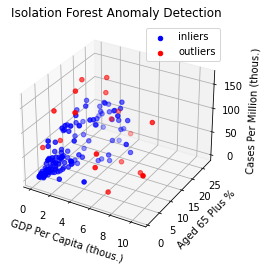

In [17]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(
    title="Isolation Forest Anomaly Detection",
    xlabel="GDP Per Capita (thous.)",
    ylabel="Aged 65 Plus %",
    zlabel="Cases Per Million (thous.)",
)
ax.scatter3D(
    inlier.gdp_per_capita / 1_1000,
    inlier.aged_65_older,
    inlier.total_cases_mill / 1_000,
    label="inliers",
    c="blue",
)
ax.scatter3D(
    outlier.gdp_per_capita / 1_1000,
    outlier.aged_65_older,
    outlier.total_cases_mill / 1_000,
    label="outliers",
    c="red",
)
_ = ax.legend()

## Summary

- we used bivariante and multivariante statistical techniques and visualizations to get a better sense of bivariante relationships among features
- we looked at common statistics, such as Pearson correlation
- we examined bivariante relationships through visualizations, with scatter plots when both features are continuous, and with grouped boxplots when one feature is categorical.
- we explored multivariante techniques for examining relationships and identifying outliers, including machine learning algorithms such as KNN and Isolation Forest